Import Library

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte

from zipfile import ZipFile

Unzip File

In [2]:
!unzip -q '/content/CroppingObjectImage.zip' -d '/content/CroppingObjectImage'


Base Path

In [3]:
base_path = '/content/CroppingObjectImage/8CroppingObjectImage'

Fungsi ekstraksi fitur HSV

In [4]:
def extract_hsv_features(image_path, size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_mean, s_mean, v_mean = np.mean(hsv[:, :, 0]), np.mean(hsv[:, :, 1]), np.mean(hsv[:, :, 2])
    h_std, s_std, v_std = np.std(hsv[:, :, 0]), np.std(hsv[:, :, 1]), np.std(hsv[:, :, 2])
    return [h_mean, s_mean, v_mean, h_std, s_std, v_std]

Fungsi ekstraksi fitur GLCM

In [5]:
def extract_glcm_features(image_path, size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img_as_ubyte(gray)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]


Load data dan ekstrak fitur

In [6]:
base_path = '/content/CroppingObjectImage/8CroppingObjectImage'
label_map = {
    '8.0-Poor Quality Beans_Cropping': 'poor',
    '8.1-Good Quality Beans_Cropping': 'good'
}

X, y = [], []
file_names = []
for label in os.listdir(base_path):
    folder = os.path.join(base_path, label)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        features = extract_hsv_features(path) + extract_glcm_features(path)
        X.append(features)
        y.append(label_map[label])
        file_names.append(file)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
# Encode label dan split data
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
df = pd.DataFrame(X, columns=[
    'h_mean', 's_mean', 'v_mean', 'h_std', 's_std', 'v_std',
    'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'
])
df['file_name'] = file_names
df['label'] = y


Model: KNN

              precision    recall  f1-score   support

        good       0.91      0.93      0.92        92
        poor       0.93      0.90      0.92        92

    accuracy                           0.92       184
   macro avg       0.92      0.92      0.92       184
weighted avg       0.92      0.92      0.92       184


Model: Logistic Regression

              precision    recall  f1-score   support

        good       0.90      0.97      0.93        92
        poor       0.96      0.89      0.93        92

    accuracy                           0.93       184
   macro avg       0.93      0.93      0.93       184
weighted avg       0.93      0.93      0.93       184


Model: Decision Tree

              precision    recall  f1-score   support

        good       0.86      0.91      0.88        92
        poor       0.91      0.85      0.88        92

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted 

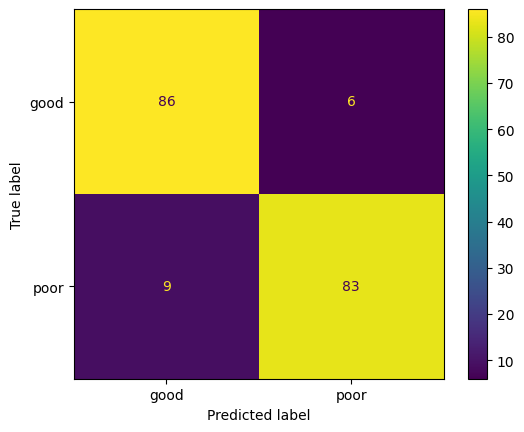

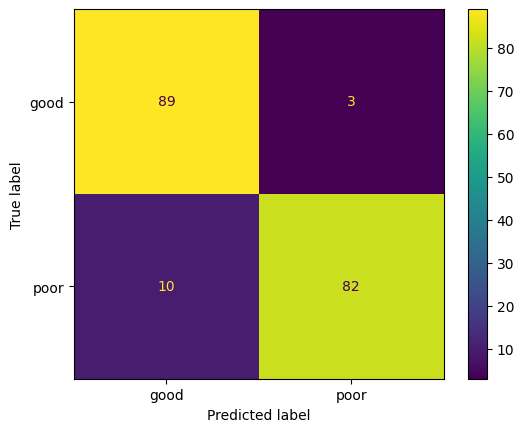

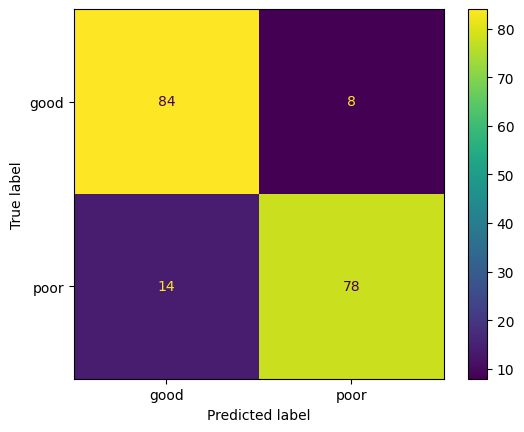

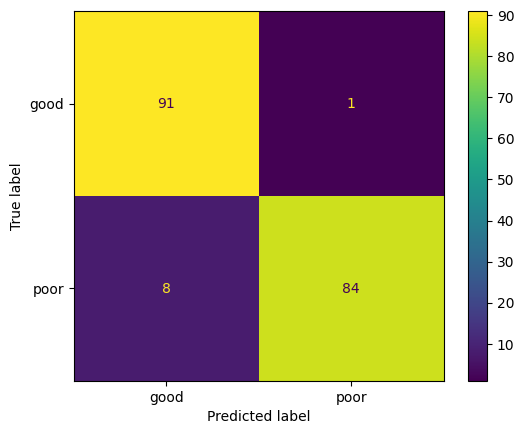

In [10]:
# Define semua model
models = {
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Evaluasi model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ])
    print(f"\nModel: {name}\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot()

df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\n\nTabel Perbandingan Model:\n")
print(df)